# Pandas Group-wise Operations

In [1]:
import pandas as pd

df = pd.DataFrame(
    {
        "user": [1, 3, 2, 1, 2, 3, 1],
        "movie": [3, 2, 3, 2, 1, 3, 1],
        "viewing hours": [0.6, 1.3, 0.6, 0.7, 0.1, 0.5, 0.9],
    }
)


In [2]:
# Question 1: How many viewing hours each user has on average?
## Compute toal viewing hours of each user
df_total = df.groupby(by="user", as_index=False).sum()
df_total

,user,movie,viewing hours
0,1,6,2.2
1,2,4,0.7
2,3,5,1.8


In [3]:
## Compute average
df_total["viewing hours"].mean()

1.5666666666666667

In [4]:
# Question 2: How many items does each user watch on average?
## Compute total number of contents each user watch
df_watch = df.groupby(by="user", as_index=False)["movie"].nunique()
df_watch

,user,movie
0,1,3
1,2,2
2,3,2


In [5]:
## Compute average
df_watch["movie"].mean()

2.3333333333333335

In [7]:
# Question 3: How many hours does each user spend on each content?
## Compute total viewing hours for each item
df_user_hrs = df.groupby(by="movie", as_index=False).agg(
    {
        "viewing hours": "sum",  # compute total hours
        "user": "nunique",  # count unique users
    }
)
df_user_hrs

,movie,viewing hours,user
0,1,1.0,2
1,2,2.0,2
2,3,1.7,3


In [8]:
## Compute average hours for each content
df_user_hrs["viewing hours"] / df_user_hrs["user"]

0    0.500000
1    1.000000
2    0.566667
dtype: float64

In [9]:
# Question 4: what percentage of time does each user spend on each movie
percentage = df.groupby(by="user")["viewing hours"].apply(
    lambda x: x / x.sum() * 100,
).droplevel(0)
percentage = percentage.rename("percentage")
df_perc = df.join(percentage, how="left")
df_perc = df_perc.sort_values(by=["user"]).reset_index(drop=True)
df_perc

,user,movie,viewing hours,percentage
0,1,3,0.6,27.272727
1,1,2,0.7,31.818182
2,1,1,0.9,40.909091
3,2,3,0.6,85.714286
4,2,1,0.1,14.285714
5,3,2,1.3,72.222222
6,3,3,0.5,27.777778


# Reshaping and Windowing of Dense Tensors

Downsampling

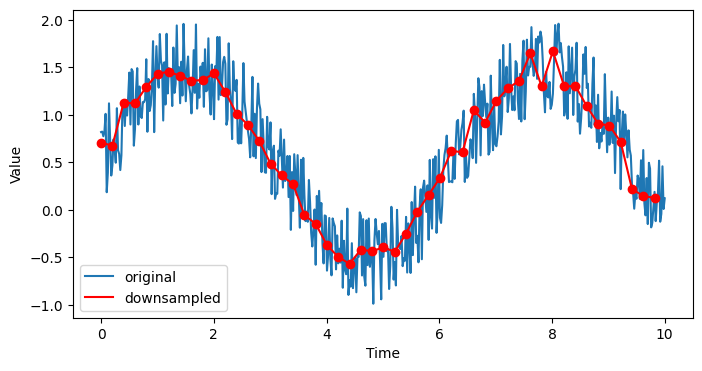

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate time series
x = np.linspace(0, 10, 500)
y = np.sin(x) + np.random.rand(len(x))

# Downsample by averaging groups of 10 elements
x_downsample = x[::10]
y_reshaped = y.reshape((-1, 10))
y_downsample = y_reshaped.mean(axis=1)

# Plot out the results
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x, y, label="original", zorder=0)
ax.plot(x_downsample, y_downsample, label="downsampled", c="r", zorder=1)
ax.scatter(x_downsample, y_downsample, c="r", zorder=2)
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()

Mean-removal

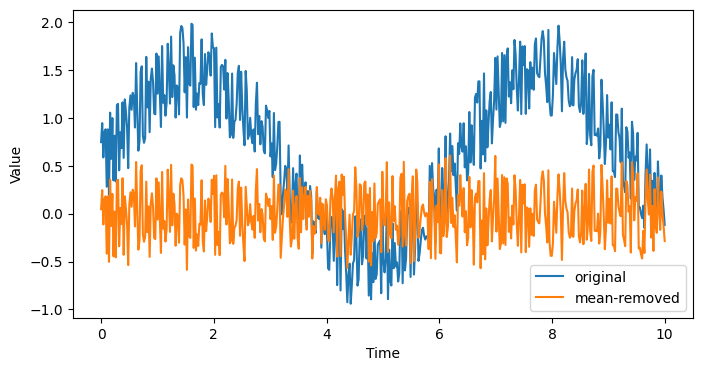

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate time series
x = np.linspace(0, 10, 500)
y = np.sin(x) + np.random.rand(len(x))

# Downsample by averaging groups of 10 elements
x_downsample = x[::10]
y_reshaped = y.reshape((-1, 10))
y_downsample = y_reshaped.mean(axis=1)
y_mean_removed = y_reshaped - y_downsample[:, None]
y_mean_removed = y_mean_removed.reshape((-1, ))

# Plot out the results
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x, y, label="original", zorder=0)
ax.plot(x, y_mean_removed, label="mean-removed", zorder=1)
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()

Sliding Window

In [13]:
import tensorflow as tf

def sliding_window_tf(X, window_size, stride, axis=0):
    """Sliding window."""
    start_indices = tf.range(0, tf.shape(X)[axis] - window_size + 1, stride)
    start_indices = tf.reshape(start_indices, (-1, 1))
    slicing_indices = tf.range(window_size)
    slicing_indices = start_indices + slicing_indices
    # use tf.gather to extract slices
    windowed = tf.gather(X, slicing_indices, axis=axis)
    # Change axis so that it follows the np conventions
    windowed = tf.experimental.numpy.moveaxis(windowed, axis+1, -1)
    
    return windowed

In [14]:
import numpy as np
import tensorflow as tf
import torch

X = np.arange(1, 12)
# Sliding window of size 3, and stride/step 2
windowed_np = np.lib.stride_tricks.sliding_window_view(
    X, window_shape=(3, ), axis=0
)[::2]
windowed_torch = torch.tensor(X).unfold(dimension=0, size=3, step=2)
windowed_tf = sliding_window_tf(X, window_size=3, stride=2, axis=0)
assert np.allclose(windowed_np, windowed_torch.numpy())
assert np.allclose(windowed_np, windowed_tf.numpy())

In [15]:
windowed_np

array([[ 1,  2,  3],
       [ 3,  4,  5],
       [ 5,  6,  7],
       [ 7,  8,  9],
       [ 9, 10, 11]])

In [16]:
windowed_torch

tensor([[ 1,  2,  3],
        [ 3,  4,  5],
        [ 5,  6,  7],
        [ 7,  8,  9],
        [ 9, 10, 11]])

In [17]:
windowed_tf

<tf.Tensor: shape=(5, 3), dtype=int64, numpy=
array([[ 1,  2,  3],
       [ 3,  4,  5],
       [ 5,  6,  7],
       [ 7,  8,  9],
       [ 9, 10, 11]])>

Moving average

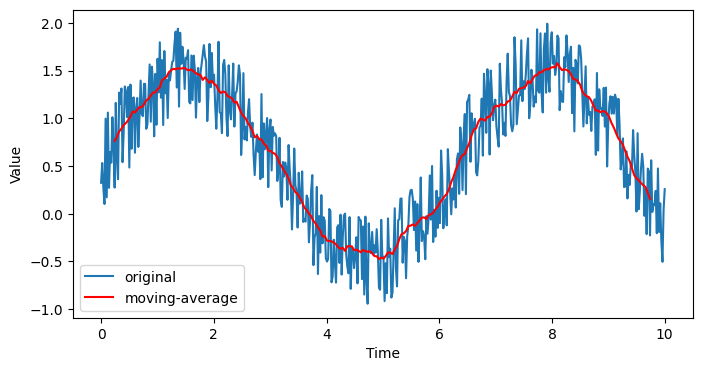

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulate time series
x = np.linspace(0, 10, 500)
y = np.sin(x) + np.random.rand(len(x))

# Create sliding window
x_windowed = np.lib.stride_tricks.sliding_window_view(x, (25, ), axis=0)[::2]
y_windowed = np.lib.stride_tricks.sliding_window_view(y, (25, ), axis=0)[::2]
# Compute moving average
x_moving_avg = x_windowed.mean(axis=1)
y_moving_avg = y_windowed.mean(axis=1)

# Equivalently in Pandas
y_moving_avg_pd = pd.Series(y).rolling(window=25, step=2).mean()
y_moving_avg_pd.dropna(inplace=True)

# Plot out the results
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x, y, label="original", zorder=0)
ax.plot(x_moving_avg, y_moving_avg, label="moving-average", zorder=1, c="r")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()

# Case Study: Vision Transformer (ViT)

In [1]:
import torch
from torch import nn
from torchsummary import summary # !pip install torch-summary==1.4.5


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, ffn_size, num_heads=2, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.mhattn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ffn_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ffn_size, embed_dim),
        )
        self.input_ln = nn.LayerNorm(embed_dim)
        self.ffn_ln = nn.LayerNorm(embed_dim)

    def forward(self, x):
        y = self.input_ln(x)
        y, _ = self.mhattn(y, y, y)
        y += x

        z = self.ffn_ln(y)
        z = self.ffn(z)
        z += y

        return z


class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_dim=(1, 28, 28),  # channel, height, width
        num_patches=(7, 7),  # along each dimension
        num_classes=10,
        embed_dim=8,
        ffn_size=32,
        num_heads=2,
        dropout=0.1,
        num_blocks=2,
    ):
        super(VisionTransformer, self).__init__()

        self.image_dim = image_dim
        self.num_patches = num_patches

        # Compute patch sizes
        err_msg = "Cannot evenly divide into patches"
        assert image_dim[1] % num_patches[0] == 0, err_msg
        assert image_dim[2] % num_patches[1] == 0, err_msg
        px_size = image_dim[1] // num_patches[0]
        py_size = image_dim[2] // num_patches[1]
        self.patch_size = px_size, py_size

        # Linear embedding of each patch
        self.patch_embed = nn.Linear(px_size * py_size, embed_dim)

        # Class token
        self.class_token = nn.Parameter(torch.rand(1, embed_dim))

        # Sinusoidal Positional encoding
        seq_len = num_patches[0] * num_patches[1] + 1
        positions = torch.arange(seq_len)
        timescales = torch.pow(
            1 / seq_len, 2 * torch.arange(embed_dim) // 2 / embed_dim
        )
        angles = positions[:, None] * timescales[None, :]
        pos_encoding = torch.zeros((seq_len, embed_dim))
        pos_encoding[0::2, :] = torch.sin(angles[0::2, :])
        pos_encoding[1::2, :] = torch.cos(angles[1::2, :])
        self.register_buffer("pos_encoding", pos_encoding)

        # Transformer encoder blocks
        self.blocks = nn.ModuleList(
            TransformerEncoderBlock(embed_dim, ffn_size, num_heads, dropout)
            for _ in range(num_blocks)
        )
        # final layer norm
        self.blocks.append(nn.LayerNorm(embed_dim))

        # Prediction head
        self.prediction_head = nn.Linear(embed_dim, num_classes)


    def patchify(self, x: torch.Tensor):
        # (batch_size, channel, patch_x, height, patch_y, width)
        patches = x.view(
            x.shape[0],
            x.shape[1],
            self.num_patches[0],
            self.patch_size[0],
            self.num_patches[1],
            self.patch_size[1],
        )
        # (batch_size, patch_x, patch_y, channel, height, width)
        patches = patches.transpose(3, 4).moveaxis(1, 3)
        # Flatten the patch dims
        # (batch_size, num_patches, channel, height, width)
        patches = patches.flatten(1, 2)
        # Faltten the patch
        # (batch_size, num_patches, num_pixels)
        patches = patches.flatten(2, 4)

        return patches

    def forward(self, x: torch.Tensor):
        # Create patches
        # (batch_size, num_patches, num_pixels)
        patches = self.patchify(x)

        # Pass through linear embedding
        # (batch_size, seq_len, emb_size)
        patches = self.patch_embed(patches)

        # Adding in the class embedding
        patches = torch.cat(
            [
                self.class_token.expand(patches.size(0), 1, -1),
                patches,
            ],
            dim=1,
        )

        # Add positional encoding
        hidden = patches + self.pos_encoding[None, :, :]

        # Pass through transformer encoder layer
        for block in self.blocks:
            hidden = block(hidden)

        # Get the class token embedding only
        output = hidden[:, 0, :]

        # Output
        output = self.prediction_head(output)

        return output

In [2]:
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST  # pip install torchvision==0.16.0
from torchvision.transforms import ToTensor
from torchsummary import summary

train_set = MNIST(
    root="./mnist", train=True, download=True, transform=ToTensor()
)
eval_set = MNIST(
    root="./mnist", train=False, download=True, transform=ToTensor()
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
eval_loader = DataLoader(eval_set, shuffle=False, batch_size=128)
train_data_size = len(train_loader)
eval_data_size = len(eval_loader)

if torch.cuda.is_available():  # NVIDIA GPU
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # Apple Silicon
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Training loop
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
num_epochs = 10

def train_epoch(model, device, train_loader, optimizer):
    model.train()
    loss_train = 0.0
    n_examples = 0
    for X, y in tqdm(train_loader):
        # Ship data to training device
        X, y = X.to(device), y.to(device)
        n_examples += len(y)
        # Forward pass
        optimizer.zero_grad()
        y_pred = model(X)
        loss = F.cross_entropy(y_pred, y, reduction="sum")
        loss_train += loss # accumulating
        loss = loss / len(y) # average
        loss.backward()
        optimizer.step()

    # Gather losses
    avg_loss = loss_train / n_examples

    return avg_loss


def eval_epoch(model, device, eval_loader):
    loss_eval = 0.0
    accuracy = 0.0
    n_examples = 0
    with torch.no_grad():
        for X, y in tqdm(eval_loader):
            X, y = X.to(device), y.to(device)
            n_examples += len(y)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y, reduction="sum")
            loss_eval += loss.item()

            # Compute accuracy
            accuracy += (y_pred.argmax(dim=1) == y).sum()

    # Gather losses
    avg_loss = loss_eval / n_examples
    avg_acc = accuracy / n_examples
    return avg_loss, avg_acc


for epoch in range(num_epochs):
    train_loss = train_epoch(model, device, train_loader, optimizer)
    eval_loss, avg_acc = eval_epoch(model, device, eval_loader)
    print(
        f"Epoch {epoch+1}/{num_epochs}:",
        f"train_loss - {train_loss:.2f},",
        f"eval_loss - {eval_loss:.2f},",
        f"eval_acc - {avg_acc:.2f}",
    )

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 49036693.14it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 60537578.12it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|███████████████████████████| 1648877/1648877 [00:00<00:00, 26539562.05it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 2815626.48it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|███████████████████████████████████████████| 79/79 [00:02<00:00, 37.86it/s]


Epoch 1/10: train_loss - 1.54, eval_loss - 1.05, eval_acc - 0.63


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 51.05it/s]


Epoch 2/10: train_loss - 0.88, eval_loss - 0.77, eval_acc - 0.75


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 51.78it/s]


Epoch 3/10: train_loss - 0.68, eval_loss - 0.62, eval_acc - 0.80


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 51.54it/s]


Epoch 4/10: train_loss - 0.59, eval_loss - 0.54, eval_acc - 0.83


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 50.84it/s]


Epoch 5/10: train_loss - 0.54, eval_loss - 0.51, eval_acc - 0.84


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 51.75it/s]


Epoch 6/10: train_loss - 0.52, eval_loss - 0.51, eval_acc - 0.84


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 51.49it/s]


Epoch 7/10: train_loss - 0.50, eval_loss - 0.48, eval_acc - 0.84


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 51.06it/s]


Epoch 8/10: train_loss - 0.48, eval_loss - 0.50, eval_acc - 0.84


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 50.31it/s]


Epoch 9/10: train_loss - 0.47, eval_loss - 0.43, eval_acc - 0.86


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 50.92it/s]

Epoch 10/10: train_loss - 0.46, eval_loss - 0.43, eval_acc - 0.87


# Bucketizing Values

In [25]:
import numpy as np
import torch
x = np.arange(10)
buckets = [0, 3, 6, 9]

# Left-inclusive [1, 1, 1, 2, 2, 2, 3, 3, 3, 4]
indices_np_false = np.digitize(x, buckets, right=False)
indices_torch_true = torch.bucketize(
    torch.tensor(x), torch.tensor(buckets), right=True
)
assert np.allclose(indices_np_false, indices_torch_true)
indices_np_false

array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4])

In [26]:
# Left-exclusive [0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
indices_np_true = np.digitize(x, buckets, right=True)
indices_torch_false = torch.bucketize(
    torch.tensor(x), torch.tensor(buckets), right=False
)
assert np.allclose(indices_np_true, indices_torch_false)
indices_np_true

array([0, 1, 1, 1, 2, 2, 2, 3, 3, 3])

In [28]:
import numpy as np
import tensorflow as tf
import torch

x = np.arange(10)
buckets = np.array([0, 3, 6, 9])
x_t = torch.tensor(x)
buckets_t = torch.tensor(buckets)

# Left inclusive [1, 1, 1, 2, 2, 2, 3, 3, 3, 4]
res = [
    ## using digitize/bucketize
    np.digitize(x, buckets, right=False),
    torch.bucketize(x_t, buckets_t, right=True),
    ## using searchsorted
    np.searchsorted(buckets, x, side="right"),
    torch.searchsorted(buckets_t, x_t, side="right"),
    tf.searchsorted(buckets, x, side="right")
]
# Pair-wise comparison
assert all([np.allclose(res[ii], res[ii+1]) for ii in range(len(res)-1)])


res

[array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4]),
 tensor([1, 1, 1, 2, 2, 2, 3, 3, 3, 4]),
 array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4]),
 tensor([1, 1, 1, 2, 2, 2, 3, 3, 3, 4]),
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4], dtype=int32)>]

In [29]:
# Left exclusive [0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
res = [
    ## using digitize/bucketize
    np.digitize(x, buckets, right=True),
    torch.bucketize(x_t, buckets_t, right=False),
    ## using searchsorted
    np.searchsorted(buckets, x, side="left"),
    torch.searchsorted(buckets_t, x_t, side="left"),
    tf.searchsorted(buckets, x, side="left")
]
# Pair-wise comparison
assert all([np.allclose(res[ii], res[ii+1]) for ii in range(len(res)-1)])

res

[array([0, 1, 1, 1, 2, 2, 2, 3, 3, 3]),
 tensor([0, 1, 1, 1, 2, 2, 2, 3, 3, 3]),
 array([0, 1, 1, 1, 2, 2, 2, 3, 3, 3]),
 tensor([0, 1, 1, 1, 2, 2, 2, 3, 3, 3]),
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 1, 1, 2, 2, 2, 3, 3, 3], dtype=int32)>]

In [30]:
import numpy as np

def bucketize_via_masking(x, buckets, side="left"):
    """Bucketize values based via broadcasting and masking."""
    # keep original shape in case we need to deal 
    # with multi-dimensional arrays
    shape = x.shape 
    x = x.flatten() # flatten
    # convert to a column vector for subsequent broadcasting
    buckets = buckets[:, None]
    if side == "left":
        mask = x > buckets # left-exclusive
    else:
        mask = x >= buckets # left-inclusive
    
    # Count the indices
    indices = mask.sum(axis=0)
    
    # reshape back to the shape of inputs
    indices = indices.reshape(shape)
    
    return indices

In [32]:
bucketize_via_masking(x, buckets)

array([0, 1, 1, 1, 2, 2, 2, 3, 3, 3])

In [33]:
bucketize_via_masking(x, buckets, side="right")

array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4])

# Segment-wise Aggregation
NumPy

In [35]:
import numpy as np
data = np.array([1, 2, 3, 2, 5, 4, 7, 2, 8, 3])
indices = np.array([0, 3, 6])
res_np = np.add.reduceat(data, indices)
res_np

array([ 6, 11, 20])

In [36]:
# non-monotonically increasing indices
indices = np.array([0, 3, 2, 6])
res_np = np.add.reduceat(data, indices)
res_np

array([ 6,  2, 14, 20])

PyTorch

In [38]:
import torch
data = torch.tensor([1, 2, 3, 2, 5, 4, 7, 2, 8, 3], dtype=float)
offsets = torch.tensor([0, 3, 6, 6, 10])
res_torch = torch.segment_reduce(data, "sum", offsets=offsets)
res_torch

tensor([ 6., 11.,  0., 20.], dtype=torch.float64)

In [39]:
# Alternative, using lengths instead of offsets
import torch
data = torch.tensor([1, 2, 3, 2, 5, 4, 7, 2, 8, 3], dtype=float)
lengths = torch.tensor([3, 3, 0, 4])
res_torch = torch.segment_reduce(data, "sum", lengths=lengths)
res_torch

tensor([ 6., 11.,  0., 20.], dtype=torch.float64)

# Mean reduce in NumPy

In [53]:
import numpy as np
def np_mean_reduceat(arr, indices, **kwargs):
    # Compute groupwise sum
    gsum = np.add.reduceat(arr, indices, **kwargs)
    # Compute groupwise count
    indicator = np.ones_like(arr)
    gcount = np.add.reduceat(indicator, indices, **kwargs)
    # Compute mean
    return gsum / gcount

x = np.array([1, 2, 3, 2, 4, 3, 5, 9, 7])
indices = np.array([0, 3, 5])
x_seg_mean = np_mean_reduceat(x, indices)
print(x_seg_mean)
x_seg_mean_tf = tf.math.segment_mean(x, [0, 0, 0, 1, 1, 2, 2, 2, 2])
print(x_seg_mean_tf)

[2. 3. 6.]
tf.Tensor([2 3 6], shape=(3,), dtype=int64)


# Tensorflow segment multiplication

In [57]:
import tensorflow as tf

def tf_sparse_segment_prod(data, indices, segment_ids, num_segments=None):
    # take log values
    data_out = tf.math.log(tf.cast(data, tf.float32))
    # Segment sum of log
    data_out = tf.sparse.segment_sum(
        data_out, indices, segment_ids, num_segments
    )
    # Raise back to exponents
    data_out = tf.exp(data_out)
    if data.dtype in (tf.int32, tf.int64):
        data_out = tf.round(data_out)
    data_out = tf.cast(data_out, data.dtype)
    return data_out


data = tf.constant([[1], [2], [3], [4], [5]])
indices = tf.constant([0, 1, 2, 3, 0])
segment_ids = tf.constant([0, 0, 1, 1, 1])
num_segments = 2
print(tf_sparse_segment_prod(data, indices,segment_ids))

tf.Tensor(
[[ 2]
 [12]], shape=(2, 1), dtype=int32)


# Reduce sqrt_n

In [78]:
    import torch

    def torch_scatter_reduce_sqrt_n(arr, indices, **kwargs):
        # Initialize accumulator
        numerator = torch.zeros(indices.max() + 1)
        denom = torch.zeros_like(numerator)
        # Compute groupwise sum
        gsum = numerator.scatter_add_(0, indices, arr)
        # Compute groupwise count
        indicator = torch.ones_like(arr)
        gcount = denom.scatter_add_(0, indices, indicator)
        # Compute the sum / sqrt_n
        return gsum / torch.sqrt(gcount)

arr = torch.tensor([1, 3, 5, 2, 5, 6], dtype=torch.float32)
indices = torch.tensor([0, 0, 1, 1, 1, 2])
torch_scatter_reduce_sqrt_n(arr, indices)

tensor([2.8284, 6.9282, 6.0000])

# Case Study: EmbeddingBag

In [89]:
import tensorflow as tf
from keras import Model, Input
from keras.layers import Layer, Embedding

class EmbeddingBag(Layer):
    """
    Keras EmbeddingBag class that summarizes embeddings of a sparse input.
    
    Inputs:
        * num_items: number of embeddings to create.
        * emb_size: size of embeddings.
        * mode: embedding summarization mode,
            one of ["mean", "max", "sum", "sqrt_n"].
        * init_weights: NumPy array of embedding values. To keep using the 
            initialized values, set `trainable=False` to prevent the 
            embedding values being updated during training.
        * **kwargs: additional keyword arguments to pass to the Keras 
            Embedding layer.
    """
    def __init__(
            self,
            num_items,
            emb_size,
            mode="mean",
            init_weights=None,
            name="embedding_bag",
            **kwargs
        ):
        super(EmbeddingBag, self).__init__(name=name)
        assert mode in ("mean", "max", "sum", "sqrt_n")
        self.mode = mode
        self.emb_size = emb_size
        self.embedding = Embedding(
            num_items, emb_size, **kwargs
        )
        # load pretrained weights
        if init_weights is not None:
            self.embedding.build([]) # initialize
            self.embedding.set_weights([init_weights])

    def call(self, 
         x: tf.SparseTensor,
         weights: tf.SparseTensor = None,
         training: bool = False
    ):
        if weights is None:
            # equal weights
            weights = x.with_values(tf.ones_like(x.values, tf.float32))
        
        # flattened (batch_size x seq_len, emb_size)
        emb = self.embedding(x.values)
        emb *= weights.values[:, None]
        
        # Group-wise aggregation
        # Assuming x is already left aligned and indices sorted
        if self.mode == "mean":
            emb = tf.sparse.segment_mean(
                emb,
                indices=tf.range(tf.shape(emb)[0]),
                segment_ids=x.indices[:, 0],
                num_segments=tf.shape(x)[0],
            )
        elif self.mode == "sum":
            emb = tf.sparse.segment_sum(
                emb,
                indices=tf.range(tf.shape(emb)[0]),
                segment_ids=x.indices[:, 0],
                num_segments=tf.shape(x)[0],
            )
        elif self.mode == "sqrt_n":
            emb = tf.sparse.segment_sqrt_n(
                emb,
                indices=tf.range(tf.shape(emb)[0]),
                segment_ids=x.indices[:, 0],
                num_segments=tf.shape(x)[0],
            )
        elif self.mode == "max":
            emb = tf.math.segment_max(emb, x.indices[:, 0])
            # Appending the potentially missing rows where the ids are empty
            emb = tf.pad(
                emb, [(0, tf.shape(x)[0] - tf.shape(emb)[0]), (0, 0)]
            )
            
        return emb

    @property
    def model(self):
        inputs = {
            "x": Input((None,), sparse=True, dtype=tf.int64, name="items"),
            "weights": Input(
                (None,), sparse=True, dtype=tf.float32, name="weights"
            ),
        }
        model = Model(inputs=inputs, outputs=self.call(**inputs))
        
        return model

Incorrect segment sum / max, which needs padding

In [80]:
import tensorflow as tf
# 6 valid values total
x = tf.ragged.constant([[1, 3], [2], [], [6, 8, 9], []]).to_sparse()
# After embedding lookup, we have a matrix of (7, 8)
emb = tf.random.uniform((len(x.values), 8))
# Summarized correctly: (5, 8)
emb_sum_correct = tf.sparse.segment_sum(
    emb, x.indices[:, 1], x.indices[:, 0], num_segments=tf.shape(x)[0]
)
emb_sum_correct

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[0.4975903 , 1.0877132 , 0.7432648 , 1.5171863 , 1.4594237 ,
        1.1596868 , 0.33605886, 0.29576135],
       [0.0380615 , 0.8091004 , 0.2293911 , 0.7445061 , 0.638896  ,
        0.257684  , 0.03000391, 0.00644255],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.9313158 , 1.7285349 , 1.4928786 , 2.226424  , 2.0001776 ,
        1.7334349 , 1.2202917 , 0.5117487 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]], dtype=float32)>

In [84]:
# Summarized incorrect: (4, 8)
emb_sum_wrong = tf.sparse.segment_sum(
    emb, x.indices[:, 1], x.indices[:, 0]
)
emb_sum_wrong

<tf.Tensor: shape=(4, 8), dtype=float32, numpy=
array([[0.4975903 , 1.0877132 , 0.7432648 , 1.5171863 , 1.4594237 ,
        1.1596868 , 0.33605886, 0.29576135],
       [0.0380615 , 0.8091004 , 0.2293911 , 0.7445061 , 0.638896  ,
        0.257684  , 0.03000391, 0.00644255],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.9313158 , 1.7285349 , 1.4928786 , 2.226424  , 2.0001776 ,
        1.7334349 , 1.2202917 , 0.5117487 ]], dtype=float32)>

In [86]:
# Summarized wrong using tf.math.segment_max: (4, 8)
emb_max_wrong = tf.math.segment_max(
    emb, x.indices[:, 0]
)
emb_max_wrong

<tf.Tensor: shape=(4, 8), dtype=float32, numpy=
array([[0.4595288 , 0.8091004 , 0.5138737 , 0.77268016, 0.8205277 ,
        0.9020028 , 0.30605495, 0.2893188 ],
       [0.43372548, 0.6408217 , 0.74961376, 0.7092377 , 0.54075396,
        0.5737481 , 0.8842329 , 0.21598732],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.9648013 , 0.6195222 , 0.938117  , 0.98766434, 0.9207165 ,
        0.9799589 , 0.2290802 , 0.706012  ]], dtype=float32)>

In [87]:
# Need to pad the empty entries occurring at the end
pad_size = tf.shape(x)[0] - tf.shape(emb_max_wrong)[0]
emb_max_correct = tf.pad(emb_max_wrong, [(0, pad_size), (0, 0)])
emb_max_correct

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[0.4595288 , 0.8091004 , 0.5138737 , 0.77268016, 0.8205277 ,
        0.9020028 , 0.30605495, 0.2893188 ],
       [0.43372548, 0.6408217 , 0.74961376, 0.7092377 , 0.54075396,
        0.5737481 , 0.8842329 , 0.21598732],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.9648013 , 0.6195222 , 0.938117  , 0.98766434, 0.9207165 ,
        0.9799589 , 0.2290802 , 0.706012  ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]], dtype=float32)>

In [93]:
layer = self = EmbeddingBag(1000, 4, mode="max")
x = tf.ragged.constant([[1, 3], [2], [], [6, 8, 9], []]).to_sparse()
emb = layer(x)

# Slice one by one
emb2 = [
    self.embedding.weights[0].numpy()[[1, 3], :].max(axis=0),
    self.embedding.weights[0].numpy()[2, :],
    tf.zeros((4,), dtype=tf.float32),
    self.embedding.weights[0].numpy()[[6, 8, 9], :].max(axis=0),
    tf.zeros((4,), dtype=tf.float32),
]

assert np.allclose(emb, emb2)
print(emb.numpy())
print(np.array(emb2))

[[ 0.02919627  0.01697044  0.03528417 -0.0077238 ]
 [ 0.03263718 -0.00511472  0.01543489 -0.00878497]
 [ 0.          0.          0.          0.        ]
 [ 0.00413871  0.03037045  0.03059256  0.01346923]
 [ 0.          0.          0.          0.        ]]
[[ 0.02919627  0.01697044  0.03528417 -0.0077238 ]
 [ 0.03263718 -0.00511472  0.01543489 -0.00878497]
 [ 0.          0.          0.          0.        ]
 [ 0.00413871  0.03037045  0.03059256  0.01346923]
 [ 0.          0.          0.          0.        ]]


In [92]:
layer.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 items (InputLayer)          [(None, None)]               0         []                            
                                                                                                  
 weights (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input.values_2 (InstancePr  (None,)                      0         ['items[0][0]']               
 operty)                                                                                          
                                                                                                  
 input.values_3 (InstancePr  (None,)                      0         ['weights[0][0]']         

# Case Study: Vocal Duration Constrained By Note Duration

In [94]:
import tensorflow as tf

def scatter_batch_2d(index, inputs, out=None, mode="add"):
    """Batch-wise scattering over a 2D matrix."""
    # Determines the length of each row for the output
    row_length = tf.cast(tf.reduce_max(index), tf.int32) + 1
    row_length = tf.maximum(tf.shape(inputs)[1], row_length)
    # start and end index of each row
    # row 0: inc[0]:inc[1], row 1: inc[1]:inc[2], ...
    inc = row_length * tf.range(tf.shape(inputs)[0]+1)
    # Compute flat indices for each element
    indices = tf.cast(index, inc.dtype) + tf.reshape(inc[:-1], (-1, 1))
    # Flatten to column vector
    indices = tf.reshape(indices, (-1, 1))
    # Flatten updates
    updates = tf.reshape(inputs, (-1,))
    if out is None: # create from zeros
        shape = (inc[-1], )
        out = tf.scatter_nd(indices, updates, shape)
    else:
        out = tf.reshape(out, (-1, ))
        if mode == "add":
            out = tf.tensor_scatter_nd_add(out, indices, updates)
        elif mode == "sub":
            out = tf.tensor_scatter_nd_sub(out, indices, updates)
        elif mode == "min":
            out = tf.tensor_scatter_nd_min(out, indices, updates)
        elif mode == "max":
            out = tf.tensor_scatter_nd_max(out, indices, updates)
        elif mode == "update":
            out = tf.tensor_scatter_nd_update(out, indices, updates)
    # reshape: (batch_size, row_length)
    out = tf.reshape(out, (tf.shape(index)[0], -1))
    
    return out


def apply_duration_constraints(dur_pred, dur_true, index, rounding="loose"):
    """
    Apply duration constraints for each phoneme.
    
    Inputs:
    * dur_pred: predicted duration of each phoneme.
    * dur_true: total duration within the grouping.
    * index: index to indicate which group each phoneme belongs to.
    """
    # Sum together total predicted duration within the group
    pred = scatter_batch_2d(index, dur_pred)
    # Broadcast the total values across all phonemes within the group
    pred = tf.gather(pred, index, axis=1, batch_dims=1)
    label = tf.gather(dur_true, index, axis=1, batch_dims=1)
    # Compute ratio: constraints / total
    ratio = tf.math.divide_no_nan(
        tf.cast(label, tf.float32), tf.cast(pred, tf.float32)
    )
    # ratio = label / pred  = dur_adj / dur_pred
    # dur_adj = dur_pred * (label / pred)
    dur_adj = ratio * tf.cast(dur_pred, tf.float32)
    # Rounding: will be off by at most 1 frame
    dur_adj = tf.cast(tf.round(dur_adj), dur_true.dtype)
    
    # Costly! Correct rounding error,
    # if 1 frame fewer, add 1 frame to the smallest duration
    # if 1 frame more, subtract 1 frame from the largest duration
    if rounding == "strict":
        # Compute groupwise statistics and broadcast to phoneme level
        min_dur = tf.ones_like(dur_adj) * tf.reduce_max(dur_adj)
        min_dur = scatter_batch_2d(index, dur_adj, out=min_dur, mode="min")
        min_dur = tf.gather(min_dur, index, axis=1, batch_dims=1)
        max_dur = tf.zeros_like(dur_adj)
        max_dur = scatter_batch_2d(index, dur_adj, out=max_dur, mode="max")
        max_dur = tf.gather(max_dur, index, axis=1, batch_dims=1)
        total_adj = scatter_batch_2d(index, dur_adj)
        total_adj = tf.gather(total_adj, index, axis=1, batch_dims=1)
        
        # Adjust
        adjustment = label - total_adj
        cond_fewer = tf.math.logical_and(
            adjustment > 0, # missing 1 frame
            dur_adj == min_dur # need to adjust on min_dur
        )
        cond_more = tf.math.logical_and(
            adjustment < 0, # extra 1 frame
            dur_adj == max_dur # need to adjust on max_dur
        )
        # combine two conditions
        cond = tf.math.logical_or(cond_fewer, cond_more)
        dur_adj = tf.where(cond, dur_adj + adjustment, dur_adj)
    
    return dur_adj

In [95]:
phonemes = tf.constant([
    [
        "I", "saw", "you", "smi", "ling", "at", "me", 
        "was", "it", "real", "or", "just", "my", "fan", "ta", "sy", 
        "<rest>", "", "", ""
    ],
    [
        "You'd", "al", "ways", "be", "there", "in", "the", "cor", "ner",
        "of", "this", "ti", "<rest>", "ny", "lit", "tle", "bar", 
        "<rest>", "", ""
    ],
])
index = tf.constant([
    [0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 6, 6, 6],
    [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 7, 7]
])

dur_true = tf.constant([
    [300, 300, 525, 450, 300, 525,   0, 0, 0, 0],
    [300, 375, 450, 150, 375, 150, 525, 0, 0, 0],
])

dur_pred = tf.constant([
    [
        71, 244, 69, 138, 74, 163, 374, 
        82, 71, 231, 70, 154, 158, 81, 76, 289, 
        79, 0, 0, 0
    ],
    [
        80, 143, 81, 77, 152, 79, 68, 82, 362, 
        69, 71, 311, 79, 78, 93, 95, 443,
        73, 0, 0
    ]
])

In [96]:
# Adjusted durations

# When setting rounding = "loose" to allow rounding errors of +/- 1 frame 
dur_adj = apply_duration_constraints(
    dur_pred, dur_true, index, rounding="loose"
)
dur_adj

<tf.Tensor: shape=(2, 20), dtype=int32, numpy=
array([[ 68, 232,  74, 147,  79, 159, 366,  81,  70, 229,  69, 148, 152,
         81,  76, 289,  79,   0,   0,   0],
       [ 79, 141,  80,  77, 152,  79,  68,  83, 367,  74,  76, 249,  63,
         62,  74,  76, 451,  74,   0,   0]], dtype=int32)>

In [97]:
# Checking total duration of the group
dur_adj_group = scatter_batch_2d(index, dur_adj)
dur_adj_group

<tf.Tensor: shape=(2, 20), dtype=int32, numpy=
array([[300, 300, 525, 449, 300, 525,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [300, 376, 450, 150, 374, 150, 525,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]], dtype=int32)>

In [98]:
# When setting rounding = "strict" to enforce total duration 
# to conform to the label
dur_adj = apply_duration_constraints(
    dur_pred, dur_true, index, rounding="strict"
)
dur_adj

<tf.Tensor: shape=(2, 20), dtype=int32, numpy=
array([[ 68, 232,  74, 147,  79, 159, 366,  81,  70, 229,  70, 148, 152,
         81,  76, 289,  79,   0,   0,   0],
       [ 79, 141,  80,  77, 151,  79,  68,  83, 367,  74,  76, 249,  63,
         63,  74,  76, 451,  74,   0,   0]], dtype=int32)>

In [99]:
# Checking total duration of the group
dur_adj_group = scatter_batch_2d(index, dur_adj)
dur_adj_group

<tf.Tensor: shape=(2, 20), dtype=int32, numpy=
array([[300, 300, 525, 450, 300, 525,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [300, 375, 450, 150, 375, 150, 525,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]], dtype=int32)>

# Case Study: Filling of Missing Values in a Sequence

In [100]:
import tensorflow as tf

event_type = tf.constant(
    [
        [
            "view",
            "click",
            "click",
            "add to cart",
            "buy",
        ],
        ["view", "view", "click", "view", "click"],
    ]
)
event_timestamp = tf.constant(
    [
        [
            "2022-03-15 06:23:24",
            "2022-03-15 06:23:38",
            "",
            "2022-03-15 06:24:58",
            "",
        ],
        ["", "", "2022-03-18 06:24:37", "", ""],
    ]
)

In [101]:
import tensorflow as tf

def ffill(x):
    """Forward filling the values of a 2D matrix row"""
    # Track indices for all values
    r, c = tf.cast(tf.shape(x), dtype=tf.int64)
    flat_indices = tf.range(r * c)
    indices = tf.stack([
        flat_indices // c,
        flat_indices % c
        ], axis=0)
    indices = tf.transpose(indices)
    
    # Indices of consecutive integers
    empty_indices = tf.where(x == "")
    f = (empty_indices[1:, 1] - empty_indices[:-1, 1]) == 1
    f = tf.concat(([False], f), 0) != tf.concat((f, [False]), 0)
    f = tf.where(f)
    f = tf.reshape(f, (-1, 2))
    
    # Compute backtracking offset values
    offset_indices = tf.ragged.range(f[:, 0], f[:, 1] + 1).flat_values
    offset_values = tf.ragged.range(f[:, 1] - f[:, 0] + 1).flat_values
    offset_values = -(offset_values+1)
    
    offsets = -tf.ones_like(empty_indices[:, 0])
    offsets = tf.tensor_scatter_nd_update(
        offsets, offset_indices[:, None], offset_values
    )
    
    # Replace the empty indices with offsets
    flat_empty_indices = empty_indices[:, 0] * c + empty_indices[:, 1]
    update_indices = tf.stack(
        [flat_empty_indices, tf.ones_like(flat_empty_indices)], axis=0
    )
    update_indices = tf.transpose(update_indices)
    indices_offset = tf.tensor_scatter_nd_add(
        indices, update_indices, offsets
    )
    
    # Address any remaining -1s. These are empty values starting at 
    # the beginning that cannot be filed. So use original indices, 
    # which is index 0
    indices_offset = tf.maximum(indices_offset, 0)
    
    # Finally, use tf.gather_nd to create the ffilled matrix
    y = tf.gather_nd(x, indices_offset) # flat
    y = tf.reshape(y, (r, c))
    
    return y

In [102]:
event_timestamp = tf.constant( # reproduced from above
    [
        [
            "2022-03-15 06:23:24",
            "2022-03-15 06:23:38",
            "",
            "2022-03-15 06:24:58",
            "",
        ],
        ["", "", "2022-03-18 06:24:37", "", ""],
    ]
)

# ffill
event_timestamp_filled = ffill(event_timestamp)
event_timestamp_filled

<tf.Tensor: shape=(2, 5), dtype=string, numpy=
array([[b'2022-03-15 06:23:24', b'2022-03-15 06:23:38',
        b'2022-03-15 06:23:38', b'2022-03-15 06:24:58',
        b'2022-03-15 06:24:58'],
       [b'', b'', b'2022-03-18 06:24:37', b'2022-03-18 06:24:37',
        b'2022-03-18 06:24:37']], dtype=object)>

In [103]:
# bfill
event_timestamp_filled = ffill(event_timestamp_filled[:, ::-1])
event_timestamp_filled

<tf.Tensor: shape=(2, 5), dtype=string, numpy=
array([[b'2022-03-15 06:24:58', b'2022-03-15 06:24:58',
        b'2022-03-15 06:23:38', b'2022-03-15 06:23:38',
        b'2022-03-15 06:23:24'],
       [b'2022-03-18 06:24:37', b'2022-03-18 06:24:37',
        b'2022-03-18 06:24:37', b'2022-03-18 06:24:37',
        b'2022-03-18 06:24:37']], dtype=object)>